# Survey of Satellite Ranges/Positions

In order to figure out what kind of performance we need in terms of optics and GoTo slew rates, we need to know where the satellites are.  To do this, we can guess lots of things, but it's probably better to just throw a bunch of TLEs through a prediction algorithm and get histograms of their tracks.

This also gives us the capability to compute the alt-az coordinates for passes, which is something we need later on in the project.

Starting by taking apart the gpredict codebase to sort out how one actually does the azimuth/elevation computations.  As with many things, it all starts with the vagaries of timebases.

## Getting to GMST

From the excellent [Astronomical Times](http://www.cv.nrao.edu/~rfisher/Ephemerides/times.html#GMST) by R. Fisher:

> GMST - Greenwich Mean Sidereal Time
> 
> Sidereal time is the measure of the earth's rotation with respect to distant celestial objects. Compare this to UT1, which is the rotation of the earth with respect to the mean position of the sun. One sidereal second is approximately 365.25/366.25 of a UT1 second. In other words, there is one more day in a sidereal year than in a solar year.
By convention, the reference points for Greenwich Sidereal Time are the Greenwich Meridian and the vernal equinox (the intersection of the planes of the earth's equator and the earth's orbit, the ecliptic). The Greenwich sidereal day begins when the vernal equinox is on the Greenwich Meridian. Greenwich Mean Sidereal Time (GMST) is the hour angle of the average position of the vernal equinox, neglecting short term motions of the equinox due to nutation.
> 
> In conformance with IAU conventions for the motion of the earth's equator and equinox [ref 7] GMST is linked directly to UT1 through the equation
>
>    GMST (in seconds at UT1=0)
>
>      = 24110.54841 + 8640184.812866 * T
>                    + 0.093104 * T^2
>                    - 0.0000062 * T^3
> where T is in Julian centuries from 2000 Jan. 1 12h UT1
>
>	    T = d / 36525
>	    d = JD - 2451545.0
>
> It might seem strange that UT1, a solar time, is determined by measuring the earth's rotation with respect to distant celestial objects, and GMST, a sidereal time, is derived from it. This oddity is mainly due our choice of solar time in defining the atomic time second. Hence, small variations of the earth's rotation are more easily published as (UT1 - Atomic Time) differences. In practice, of course, some form of sidereal time is involved in measuring UT1.

Another good resource for finding GMST is the [Approximate Sidereal Time page from USNO](http://aa.usno.navy.mil/faq/docs/GAST.php).  They give a handy formula which returns GMST (in hours) good to 0.1 seconds per century:

> GMST = 18.697374558 + 24.06570982441908 D

Where D is floating point days since `2000-01-01T12:00:00Z`.  Because who needs seconds when you can have arbitrary fractions of days instead?


In [1]:
%pylab inline
import numpy as np # Going to use numpy for lots of matrix stuff, sorrynotsorry

class GMST:
    T0_utc = 946728000 # 2000-01-01T12h00Z is the zero point for T below
    GMST0 = 18.697374558
    SID_HRS = 24.06570982441908 # Clock hours in a sideral day
    
    
    @classmethod
    def from_unix(cls, t_utc):
        """Compute GMST (in radians) based on unix time
        
        Based on a formula from http://aa.usno.navy.mil/faq/docs/GAST.php
        
        This formula is reportedly good to 0.1sec/century, which is plenty
        good for SGP4 work, where we're willing to conflate UTC and UT1, which
        is a margin of a millenium(!) of drift due to this formula.
        
        NB: I'm pretty sure we get all the significant figures in the constants
        here, but it's not super clear, so the drift may be higher than
        reported.  For this application, I can't be bothered to check up on this,
        but if you need super high precision, this is a bit of an XXX comment.
        """
        
        d = (t_utc - GMST.T0_utc)/86400.0
        gmst_h = (GMST.GMST0 + GMST.SID_HRS*d) % 24 # GMST given in 24.00 hour periods
        gmst_rad = gmst_h / 24.00*2*np.pi # 24.00 hr, so not the same as WGS84.omega
        return gmst_rad

Populating the interactive namespace from numpy and matplotlib


All our coordinates work is done in [Earth-centered inertial](https://en.wikipedia.org/wiki/Earth-centered_inertial) coordinates, where you, sitting in a chair, are whipping around in a circle about the Earth's axis at rather high speed.  The units in the codebase gpredict's algorithm are derived from seems to use kilometers for units, so we'll use that as well internally.

All of this is computed using the WGS84 model of the Earth, excerpts of which we include below.  This is redundant with the model constants present in any of the orbital libraries, so maybe we don't need this.  But hey, this is expedient, and we're currently just experimenting.

So we start with WGS84 and get to code that can find out exactly where your chair is in 3-space about the center of the earth at any given point in time, as well as your velocity at that point in time.

In [2]:
class WGS84:
    # A container for random WGS84 constants; NB: this duplicates stuff in sgp4, probably can be removed
    f = 1/298.257223560 # flattening of the spheroid, no units
    a = 6378.137 # equatorial radius, km
    omega_e = 366.25/365.25 # ratio of sidereal day to solar day
    omega = 7.292115e-5 # earth rotation rate, radians/second. Note! this is 2pi/_sidereal_ day
                        # Alternately, omega = 2*pi/86400*omega_e
    

class ECIPoint:
    "Represents an (x,y,z) point with velocity in the Earth-Centered Inertial coordinate system"
    def __init__(self, pos, vel):
        self.pos = np.array(pos)
        self.vel = np.array(vel)
        
    def speed(self):
        # Get the absolute speed of this object
        return np.sqrt(np.sum(self.vel**2))
    
    def range_to(self, eci2):
        # Get the range from this point to the second point
        return eci2.pos - self.pos
    
    def range_vel(self, eci2):
        return eci2.vel - self.vel
        
    def __repr__(self):
        return "(%0.3f,%0.3f,%0.3f) km @ (%0.3f,%0.3f,%0.3f) km/s" % (self.pos[0], self.pos[1], self.pos[2], self.vel[0], self.vel[1], self.vel[2])
    
class ECIEarthPoints:
    "Given a lat/long and altitude, compute an ECIPoint for any given unix time."
    def __init__(self, lat, lon, alt_m):
        """Create an ECIPoint generator for the given position.
        
        * (lat,lon) in radians, because degress includes further decimal vs hms arbitrariness
        * alt above earth radius in meters
        """
        self.lat = lat
        self.lon = lon
        self.alt = alt_m/1e3 # Convert to km
        
    def lmst(self, t):
        # Get the local sideral mean time for unix time t, in radians
        
        gmst = GMST.from_unix(t)
        theta = gmst + self.lon # local mean sidereal time
        return theta
        
    def __repr__(self):
        return "(%0.4f,%0.4f)@%0.1fm" % (np.rad2deg(self.lat), np.rad2deg(self.lon), self.alt*1e3)
        
    def at(self, t):
        # Returns the ECIPoint for the given position at time t
        
        theta = self.lmst(t)
        
        # Correct for spheroid
        c = np.sqrt(1 + WGS84.f*(WGS84.f-2)*(np.sin(self.lat)**2))
        sq = c*(1-WGS84.f)**2
        
        # no idea why this is called achcp. 
        achcp = (WGS84.a*sq + self.alt) * np.cos(self.lat)
        
        pos_x = achcp*np.cos(theta)
        pos_y = achcp*np.sin(theta)
        pos_z = (WGS84.a*c + self.alt)*np.sin(self.lat)
        
        vel_x = WGS84.omega * -1*pos_y # derivative of sin and cos are handy here
        vel_y = WGS84.omega *    pos_x
        vel_z = 0 # please don't throw your telescope, or this gets super ugly.
        
        return ECIPoint((pos_x,pos_y,pos_z), (vel_x,vel_y,vel_z))
    
    
    def v_to(self, t, pt):
        # Get a vector in topocentric coordinates at the given ECIPoint at unix time t
        
        obs_pt = self.at(t)
        theta = self.lmst(t)
        
        v_range = obs_pt.range_to(pt)
        
        l_c,l_s = np.cos(self.lat), np.sin(self.lat) # we use these a lot below
        t_c,t_s = np.cos(theta), np.sin(theta)
        
        # The axes used here are slightly annoying to me: they're due south, due east, and up.
        # This is almost certainly done to keep some handedness constraints in the math, but,
        # dangit three-space, why are you so difficult?
        xform = np.array([
            [l_s*t_c, l_s*t_s, -l_c],
            [-t_s,    t_c,        0],
            [l_c*t_c, l_c*t_s,  l_s]]) # prettier if you swap y and z, but that's confusing
        
        vec_sez = xform.dot(v_range)
        return vec_sez
    
    def alt_az(self, t, pt):
        # Returns the elevation and azimuth of the given point in space at time t from here
        vec_sez = self.v_to(t,pt)
        distance = np.sqrt(np.sum(vec_sez**2))
        
        azimuth = np.arctan2(vec_sez[1], -1*vec_sez[0])
        elevation = np.arcsin(vec_sez[2]/distance)
        
        if azimuth < 0:
            azimuth += 2*np.pi

        return (elevation, azimuth)

That c/sq/achcp business is really ugly.  Can we get rid of it?  let's see what its bounds look like:

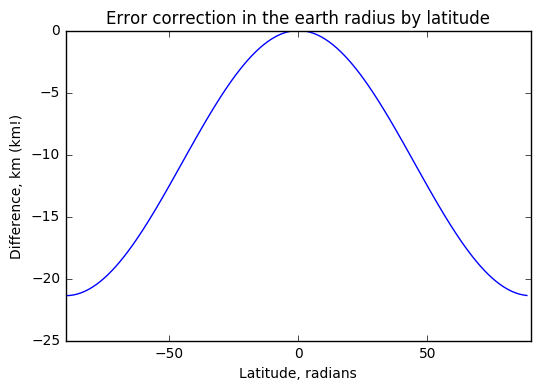

In [3]:
lats = np.arange(-90.0, 90, 1.5)
plot(lats, (np.sqrt(1 + WGS84.f*(WGS84.f-2)*np.sin(lats*np.pi/180.0)**2)-1)*WGS84.a)
title("Error correction in the earth radius by latitude")
xlabel("Latitude, radians")
ylabel("Difference, km (km!)")
xlim(-90,90);

Hunh, nope.  We really want that, unless we're cool with 20km errors in altitude(!).  Even where I'm at, at a modest 37.7°N, the error is still many kilometers of vertical error, which does matter (in terms of direction to target, especially around altitude/visibility calculations).

Okay, so, not to be self-centered, what does this look like for me?  Let's see how things are changing at my QTH (station location).

In [4]:
import time

In [5]:
qth_deg = (37.728206,-122.407863) # QTH for AJ9BM
qth = ECIEarthPoints(np.deg2rad(qth_deg[0]), np.deg2rad(qth_deg[1]), 25)
tnow = time.time()
for _ in range(5):
    tnow += 1
    print tnow, qth, qth.at(tnow)

1511751376.8 (37.7282,-122.4079)@25.0m (4893.105,-1050.386,3898.008) km @ (0.077,0.357,0.000) km/s
1511751377.8 (37.7282,-122.4079)@25.0m (4893.181,-1050.029,3898.008) km @ (0.077,0.357,0.000) km/s
1511751378.8 (37.7282,-122.4079)@25.0m (4893.258,-1049.672,3898.008) km @ (0.077,0.357,0.000) km/s
1511751379.8 (37.7282,-122.4079)@25.0m (4893.334,-1049.316,3898.008) km @ (0.077,0.357,0.000) km/s
1511751380.8 (37.7282,-122.4079)@25.0m (4893.411,-1048.959,3898.008) km @ (0.076,0.357,0.000) km/s


That's disappointingly dull.  Let's see what the changes look like throughout a sidereal day:

In [6]:
for t in np.arange(tnow, tnow+86164, 86164/4):
    print t, qth.at(t)

1511751380.8 (4893.411,-1048.959,3898.008) km @ (0.076,0.357,0.000) km/s
1511772921.8 (1048.967,4893.409,3898.008) km @ (-0.357,0.076,0.000) km/s
1511794462.8 (-4893.407,1048.975,3898.008) km @ (-0.076,-0.357,0.000) km/s
1511816003.8 (-1048.983,-4893.406,3898.008) km @ (0.357,-0.076,0.000) km/s


Okay, so that looks like a good quadrature speed, with no changes in the vertical component.  What does it look like for someone at the north pole?

In [7]:
qth_np = ECIEarthPoints(np.pi/2, 0, 0)
for t in np.arange(tnow, tnow+86164, 86164/4):
    print t, qth_np.at(t)
    
# Sweep the longitude as well:
for lon in np.arange(-np.pi, np.pi, np.pi/6.0):
    qth_np_i = ECIEarthPoints(np.pi/2, lon, 0)
    pt = qth_np_i.at(tnow)
    if pt.speed() > 0.001: # Check their speed, instead of futzing around
        print "Error!"   

1511751380.8 (-0.000,0.000,6356.752) km @ (-0.000,-0.000,0.000) km/s
1511772921.8 (-0.000,-0.000,6356.752) km @ (0.000,-0.000,0.000) km/s
1511794462.8 (0.000,-0.000,6356.752) km @ (0.000,0.000,0.000) km/s
1511816003.8 (0.000,0.000,6356.752) km @ (-0.000,0.000,0.000) km/s


Okay, so they have a z-component, but no x,y, and zero velocity, which is good.  Now to check out our pointing work.  First up, let's just do some trivial geocentric stuff.  For instance, what about a point straight up from my QTH?

In [8]:
qth_but_higher = ECIEarthPoints(qth.lat, qth.lon, qth.alt+1000)
print qth
print qth_but_higher

p1 = qth_but_higher.at(0)
print map(np.rad2deg, qth.alt_az(0, p1)) # because i'm human after all

(37.7282,-122.4079)@25.0m
(37.7282,-122.4079)@1000.0m
[90.0, 169.1793051655886]


Now, let's sanity check all the cardinal points:

In [9]:
steps = [0.01, 0.01, 1000]
labels = "NEZ"
for d in range(3):
    c2 = [qth.lat, qth.lon, qth.alt]
    c2[d] += steps[d]

    qth_offset = ECIEarthPoints(c2[0],c2[1],c2[2])
    p2 = qth_offset.at(0)
    
    aa = qth.alt_az(0, p2)
    print "+", labels[d], map(lambda r: "%0.1f" % np.rad2deg(r), aa)
    
    c2[d] -= 2*steps[d]

    qth_offset = ECIEarthPoints(c2[0],c2[1],c2[2])
    p2 = qth_offset.at(0)
    aa = qth.alt_az(0, p2)
    print "-", labels[d], map(lambda r: "%0.1f" % np.rad2deg(r), aa)

+ N ['-0.3', '360.0']
- N ['-0.3', '180.0']
+ E ['-0.3', '89.8']
- E ['-0.3', '270.2']
+ Z ['90.0', '169.2']
- Z ['-90.0', '218.4']


Okay, how about the top of Salesforce Tower?  It's at (37.7899,-122.3990887) and is about 325m tall. Let's call it 350m to deal with the ground under it.

In [10]:
qth_salesforce = ECIEarthPoints(np.deg2rad(37.7899), np.deg2rad(-122.3990887), 325)

p1 = qth_salesforce.at(0)
print map(np.rad2deg, qth.alt_az(0, p1)) # because i'm human after all

[2.4643196669289997, 6.3861090838427721]


In [11]:
qth_transamerica = ECIEarthPoints(np.deg2rad(37.7951775), np.deg2rad(-122.4027787), 275)

p1 = qth_transamerica.at(0)
print map(np.rad2deg, qth.alt_az(0, p1)) # because i'm human after all


p1 = qth_transamerica.at(tnow)
print map(np.rad2deg, qth.alt_az(tnow, p1)) # because i'm human after all

[1.8911662452640683, 3.4187422277854895]
[1.8911662452640501, 3.4187422277843407]


These don't look totally insane, though the elevations don't match what I measure with my cellphone theodolite.  But it's probably a bit wonky anyway, so we'll live with this for now.

## Geostationary Orbits

Before we get into crazypants LEO stuff, let's try a trivial thing which we can check online various places: the look angle for geostationary satellites.  These are well-documented because of satellite TV, and getting a rough location on the satellite should be trivial, because it's just at its longitude, latitude 0, with an altitude of 35,786km or so. Let's go for the DirecTV satellite at 110.1°W.  Per the [DirecTV-5 wikipedia page](https://en.wikipedia.org/wiki/DirecTV-5), its orbital parameters are 109.8°W and an altitude of 35,780-35,805km.  We'll call it 35,786km because we like textbook numbers.  We expect about 44° elevation and 160° azimuth, courtesy a few online look angle calculators (use multiple to cross-check).

In [12]:
directv_5 = ECIEarthPoints(0, np.deg2rad(-109.8), 35786e3)

p_directv_5 = directv_5.at(0)
print map(np.rad2deg, qth.alt_az(0, p_directv_5))

[44.315989319556891, 159.93654200383892]


Okay, that looks good.  So, we have a way to get alt-az coordinates for a given ECI frame all put together, and we hopefully have captured the rotation of the earth.  Now to add satellites!